# Set Up

In [1]:
! pip3 install tensornetwork

     |████████████████████████████████| 368kB 5.0MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
# Install Packages
import tensorflow as tf
import tensornetwork as tn

from skimage.measure import block_reduce
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [3]:
# Importing the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


# Processing

In [4]:
# Crop Function
def crop(image, boundary):
  pixels_df = pd.DataFrame(image)
  rem_top = pixels_df.drop(pixels_df.head(boundary).index)
  rem_bottom = rem_top.drop(rem_top.tail(boundary).index)
  rem_left_right = rem_bottom.drop(rem_bottom.columns[[0, 1, 12, 13]], axis = 1)
  cropped_array = rem_left_right.to_numpy()
  return cropped_array

In [5]:
# Preprocessing Function
def preprocessing(image): # image in form train_X[i]
  pixels = np.array(image) / 255 # normalising
  pixels = block_reduce(pixels, block_size=(2,2), func = np.max) # reduce pixel number, could also use np.mean
  # pixels = np.round(pixels) # converts to black and white, can be commented out to remain grayscale
  pixels = crop(pixels, 2) # crop 2 pixel boundary from image
  return pixels

In [6]:
# Show Image Function
def show_im(image):
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.show()

# Creating Feature Map

In [7]:
# Flatten Function
def flatten(image):
  p = image.flatten()
  tensors = [p]
  return tensors

In [8]:
# Feature Map using [p, 1-p] mapping Function
def p_feat_map(pixel_value): # Returns 2D vector Phi(p) = [1-p,p]   
    feature_vector = np.array([1 - pixel_value, pixel_value])    
    return feature_vector

In [9]:
# Feature Map using cos sin mapping Function
def cos_sin_feat_map(pixel_value):
  cos = np.cos(np.pi*pixel_value/2)
  sin = np.sin(np.pi*pixel_value/2)
  feature_vector = np.array([cos, sin])
  feature_vector = np.round(feature_vector)
  return feature_vector

In [10]:
# Feature Map using p, p^2 mapping Function
def p2_feat_map(pixel_value): # Returns 2D vector Phi(p) = [p,p^2]   
    feature_vector = np.array([pixel_value, pixel_value^2])    
    return feature_vector

In [11]:
# Running through all pixels in an image 
def feature_map(image, local_mapping): # image is flattened pixels
    vectors = []
    
    for pixel_value in image:
        feature_vector = local_mapping(pixel_value)
        vectors += [feature_vector]   
    return vectors

# Creating MPS

In [12]:
# Zero Valued MPS
def create_zero_MPS(number_of_pixels, bond_dimension, local_feature_map_dimension):  
    # First, create the tensors 
    tensors = []   
    for pixel_idx in range(number_of_pixels):        
        if pixel_idx == 0: # left boundary tensor has only a single bond on the right           
            tensor_shape = (local_feature_map_dimension, 1,bond_dimension)           
        elif  pixel_idx == number_of_pixels -1: # right boundary tensor has only a single bond on the left       
            tensor_shape = (local_feature_map_dimension, bond_dimension, 1)           
        else: # all other tensors have two bonds           
            tensor_shape = (local_feature_map_dimension, bond_dimension, bond_dimension)                                  
        tensor = tn.Node(np.zeros(tensor_shape)) # zero sample
        tensors += [tensor]

    return tensors

## Image to MPS

In [13]:
def image_to_mps(image, feature_mapping): # image in form train_X[i]
  processed = np.array(preprocessing(image))
  flattened = flatten(processed)
  mapped = feature_map(flattened, feature_mapping)
  init_mps_tens = create_zero_MPS(100, 1, 2)
  
  for pixel_idx in range(100):
    init_mps_tens[pixel_idx].tensor = np.reshape([np.asarray(mapped).T[pixel_idx]], (1,2,1))

  image_mps = init_mps_tens

  return image_mps

## Creating random MPS

In [14]:
def create_rand_MPS(phys_dim, bond_dim, rank):
  np.random.seed(3)
  mpstateA = tn.FiniteMPS.random(d = [phys_dim for _ in range(rank)], D = [bond_dim for _ in range(rank-1)], dtype = np.complex128)
  random_mps = [tn.Node(np.conj(tensor), f'A{i}') for i, tensor in enumerate(mpstateA.tensors)]
  return random_mps

## Comparison of image and random MPS

---



In [15]:
testmps1 = image_to_mps(train_X[0], cos_sin_feat_map)

In [16]:
testmps2 = image_to_mps(train_X[10], p_feat_map)

In [17]:
overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(train_X))

  rank = 100

  image_mps = image_to_mps(train_X[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  overlaps += [overlap]

#print(overlaps)

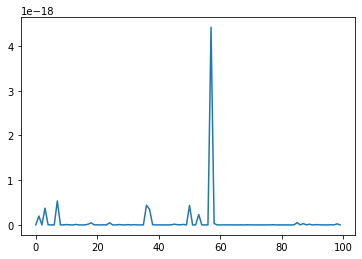

In [18]:
plt.plot(overlaps)

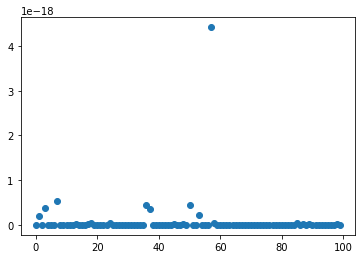

In [19]:
plt.scatter(range(0,100,1),overlaps)

In [20]:
p_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(train_X))

  rank = 100

  image_mps = image_to_mps(train_X[random_image_id], p_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  p_overlaps += [overlap]

#print(overlaps)

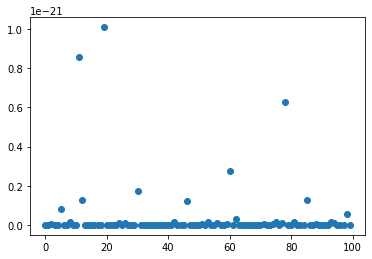

In [21]:
plt.scatter(range(0,100,1), p_overlaps)

In [22]:
p2_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(train_X))

  rank = 100

  image_mps = image_to_mps(train_X[random_image_id], p_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  p2_overlaps += [overlap]

#print(overlaps)

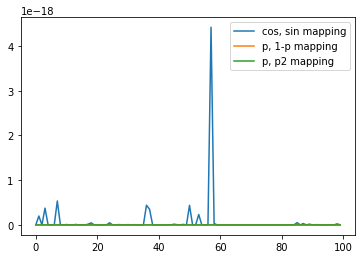

In [23]:
plt.plot(overlaps, label = 'cos, sin mapping')
plt.plot(p_overlaps, label='p, 1-p mapping')
plt.plot(p2_overlaps, label='p, p2 mapping')
plt.legend()

### Histograms

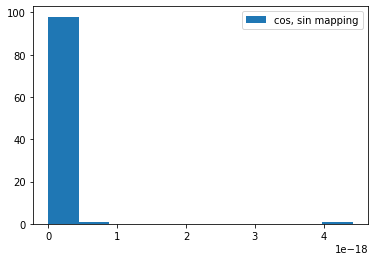

In [24]:
# Histogram
plt.hist(overlaps, label = 'cos, sin mapping')
plt.legend()

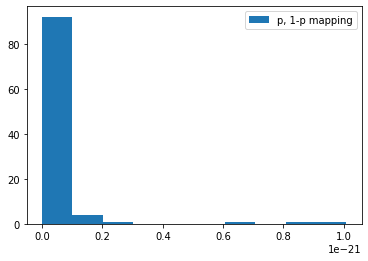

In [25]:
plt.hist(p_overlaps, label='p, 1-p mapping')
plt.legend()

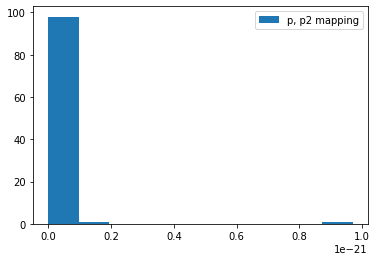

In [26]:
plt.hist(p2_overlaps, label='p, p2 mapping')
plt.legend()

### Loss

In [27]:
def loss(data):
  softmax_fx = np.exp(data)/sum(np.exp(data))
  CE = - sum(np.log(softmax_fx))
  return CE

In [28]:
-sum(np.log(np.exp(overlaps)/sum(np.exp(overlaps))))

460.5170185988085

In [29]:
ce = [0]*3
ce[0] = loss(overlaps)
ce[1] = loss(p_overlaps)
ce[2] = loss(p2_overlaps)

<BarContainer object of 3 artists>

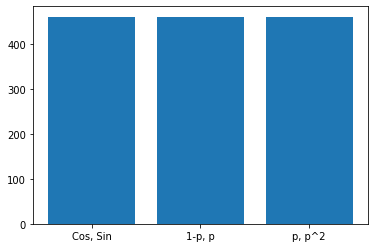

In [30]:
plt.bar(['Cos, Sin','1-p, p','p, p^2'],ce)

# Creating MPS from Specific Classes


In [31]:
y_train_0 = []
x_train_0 = []

for i in range(len(train_y)):
  if train_y[i] == 0:
    y_train_0.append(train_y[i])
    x_train_0.append(train_X[i])

y_train_1 = []
x_train_1 = []

for i in range(len(train_y)):
  if train_y[i] == 1:
    y_train_1.append(train_y[i])
    x_train_1.append(train_X[i])

y_train_2 = []
x_train_2 = []

for i in range(len(train_y)):
  if train_y[i] == 2:
    y_train_2.append(train_y[i])
    x_train_2.append(train_X[i])

y_train_3 = []
x_train_3 = []

for i in range(len(train_y)):
  if train_y[i] == 3:
    y_train_3.append(train_y[i])
    x_train_3.append(train_X[i])

y_train_4 = []
x_train_4 = []

for i in range(len(train_y)):
  if train_y[i] == 4:
    y_train_4.append(train_y[i])
    x_train_4.append(train_X[i])

y_train_5 = []
x_train_5 = []

for i in range(len(train_y)):
  if train_y[i] == 5:
    y_train_5.append(train_y[i])
    x_train_5.append(train_X[i])

y_train_6 = []
x_train_6 = []

for i in range(len(train_y)):
  if train_y[i] == 6:
    y_train_6.append(train_y[i])
    x_train_6.append(train_X[i])

y_train_7 = []
x_train_7 = []

for i in range(len(train_y)):
  if train_y[i] == 7:
    y_train_7.append(train_y[i])
    x_train_7.append(train_X[i])

y_train_8 = []
x_train_8 = []

for i in range(len(train_y)):
  if train_y[i] == 8:
    y_train_8.append(train_y[i])
    x_train_8.append(train_X[i])

y_train_9 = []
x_train_9 = []

for i in range(len(train_y)):
  if train_y[i] == 9:
    y_train_9.append(train_y[i])
    x_train_9.append(train_X[i])

In [32]:
zero_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_0))

  rank = 100

  image_mps = image_to_mps(x_train_0[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  zero_overlaps += [overlap]

In [33]:
one_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_1))

  rank = 100

  image_mps = image_to_mps(x_train_1[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  one_overlaps += [overlap]

In [34]:
two_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_2))

  rank = 100

  image_mps = image_to_mps(x_train_2[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  two_overlaps += [overlap]

In [35]:
three_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_3))

  rank = 100

  image_mps = image_to_mps(x_train_3[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  three_overlaps += [overlap]

In [36]:
four_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_4))

  rank = 100

  image_mps = image_to_mps(x_train_4[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  four_overlaps += [overlap]

In [37]:
five_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_5))

  rank = 100

  image_mps = image_to_mps(x_train_5[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  five_overlaps += [overlap]

In [38]:
six_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_6))

  rank = 100

  image_mps = image_to_mps(x_train_6[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  six_overlaps += [overlap]

In [39]:
seven_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_7))

  rank = 100

  image_mps = image_to_mps(x_train_7[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  seven_overlaps += [overlap]

In [40]:
eight_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_8))

  rank = 100

  image_mps = image_to_mps(x_train_8[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  eight_overlaps += [overlap]

In [41]:
nine_overlaps = []

for i in range(100):

  random_image_id = random.randint(0,len(x_train_9))

  rank = 100

  image_mps = image_to_mps(x_train_9[random_image_id], cos_sin_feat_map)
  random_mps = create_rand_MPS(2, 1, 100)

  image_mps[0][0] ^ random_mps[0][0]
  image_mps[-1][2] ^ random_mps[-1][2]
  [image_mps[k][2] ^ image_mps[k+1][0] for k in range(rank-1)]
  [random_mps[k][2] ^ random_mps[k+1][0] for k in range(rank-1)]
  [image_mps[k][1] ^ random_mps[k][1] for k in range(rank)]
  contraction = image_mps[0] @ random_mps[0]

  for k in range(1, len(image_mps)):
      contraction = contraction @ image_mps[k] @ random_mps[k]
   
  overlap = np.abs(contraction.tensor)
  nine_overlaps += [overlap]

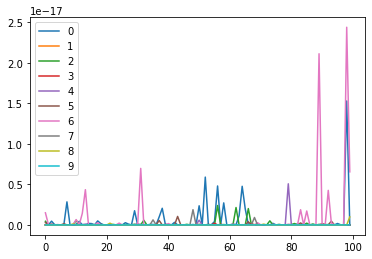

In [42]:
plt.plot(zero_overlaps, label='0')
plt.plot(one_overlaps, label='1')
plt.plot(two_overlaps, label='2')
plt.plot(three_overlaps, label='3')
plt.plot(four_overlaps, label='4')
plt.plot(five_overlaps, label='5')
plt.plot(six_overlaps, label='6')
plt.plot(seven_overlaps, label='7')
plt.plot(eight_overlaps, label='8')
plt.plot(nine_overlaps, label='9')
plt.legend()